In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
import os

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "img",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name= dataset.class_names

In [5]:
len(dataset)

68

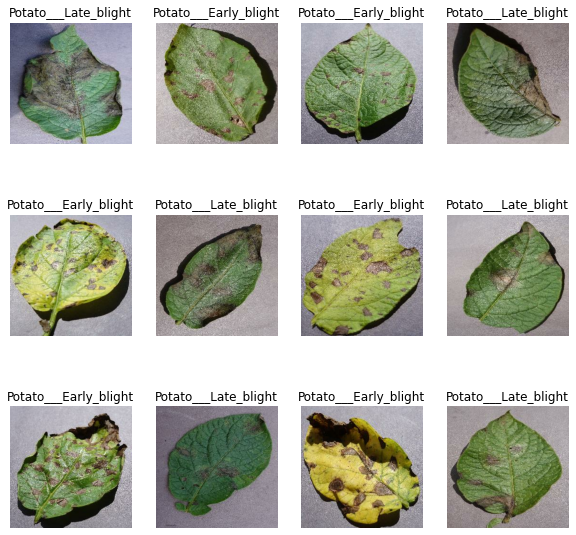

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_name[label_batch[i]])

Traininng => 80%
Testing => 10% Validation, 10% Testing

In [7]:
def get_dataset_seperated(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size= 10000):
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_seperated(dataset)

In [9]:
len(train_ds)

54

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmetation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_rescale,
    data_augmetation,
    layers.Conv2D(32,(3,3),activation ='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history =  model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 170s 3s/step - loss: 0.9106 - accuracy: 0.4878 - val_loss: 0.8470 - val_accuracy: 0.6042
Epoch 2/50
54/54 [==============================] - 153s 3s/step - loss: 0.6004 - accuracy: 0.7309 - val_loss: 0.5002 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 154s 3s/step - loss: 0.3851 - accuracy: 0.8385 - val_loss: 0.4268 - val_accuracy: 0.8281
Epoch 4/50
54/54 [==============================] - 152s 3s/step - loss: 0.3084 - accuracy: 0.8733 - val_loss: 0.3118 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 184s 3s/step - loss: 0.2404 - accuracy: 0.8993 - val_loss: 0.6885 - val_accuracy: 0.7865
Epoch 6/50
54/54 [==============================] - 189s 3s/step - loss: 0.2780 - accuracy: 0.8918 - val_loss: 0.3985 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 189s 4s/step - loss: 0.2469 - accuracy: 0.9045 - val_loss: 0.4158 - val_accuracy: 0.8333
Epoch 8/50
54

In [17]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 720ms/step - loss: 0.1367 - accuracy: 0.9531


In [18]:
scores

[0.1366768777370453, 0.953125]

In [19]:
history

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

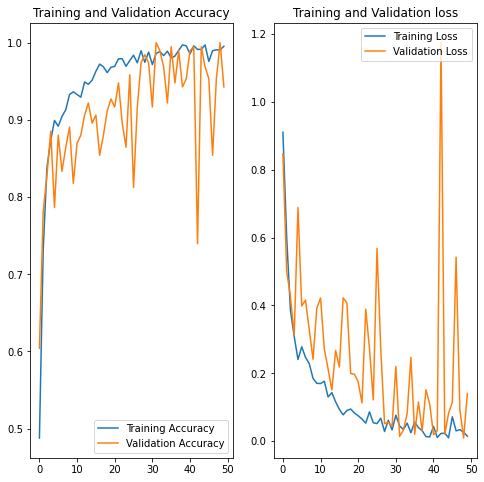

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions= model.predict(img_array)
    
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

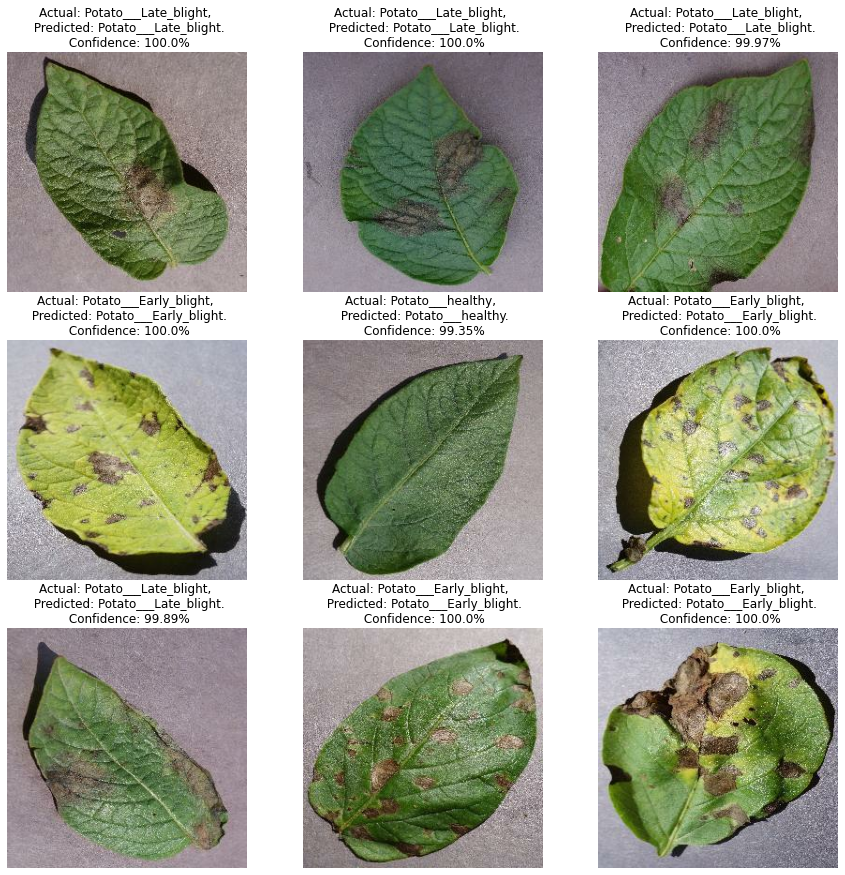

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class= class_name[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [27]:
model_version=max ([int(i) for i in os.listdir("../model") + [0]]) + 1
model.save(f"../model/{model_version}")

KeyError: "Failed to add concrete function 'b'__inference_sequential_2_layer_call_fn_21044'' to object-based SavedModel as it captures tensor <tf.Tensor: shape=(), dtype=resource, value=<Resource Tensor>> which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."